# Traffic congestion attack detection in VANETs

## Introduction

Ad-hoc networks are a decentralized wireless network model, composed of several devices, with the function of sending and receiving messages. One type of ad-hoc network is the vehicular ad-hoc network (VANET). VANETs have a dynamic topology, that is, the connection between vehicles can change over time.

VANETs mainly contain two types of communication:

* Road-to-vehicle communication
* **Vehicle-to-vehicle communication**

The applications of VANETs are varied, but are mainly based on the exchange of cooperative messages, for understanding and decision-making in traffic. There are two main elements within a VANET, the On-Board Unit (OBU) and the Road Side Unit (RSU). The OBU is responsible for sending vehicle information on the network, such as position and speed, while the RSU can send road information, such as weather and accidents that have occurred.

These networks, like any other, can be the target of attacks that prevent them from functioning correctly. One of the possible attacks is the congestion simulation attack, where an attacker simulates several other vehicles stopped or at low speed near another vehicle, in a way that forces it to stop as well.

To mitigate attacks, one possibility is to use some technique to detect when an attack occurs and then notify some entity so that a decision can be made regarding it. It can also be used later as a form of offline audit.

Therefore, the objective of this work is to find and apply a technique that uses graph neural networks to detect congestion attacks.

## Methodology

To determine the technique that will be applied to detect attacks, I searched the models implemented in the Torch Geometric library for any fit in the context of dynamic and temporal graphs. I decided to use TGN, as it was the best for the type of graph being treated. It will be better explained in the following sections.

From the dataset, the idea of this APS arises primarily from the VeReMi dataset, which contains the congestion attack and will be the main object of study. It will be more detailed later.

## Dataset

VeReMi [5] is a dataset simulated with VEINS that contains failures and attacks in VANETs. It is presented in the form of "log" messages between vehicles, and contains two types of messages, GPS (receiving the vehicle's own position, speed, acceleration and current direction) and BSM (messages from other vehicles receiving the position, speed, acceleration and steering of nearby vehicles). Only a part of the dataset containing genuine behavior and congestion attack behavior is used.

In [7]:
import json
import math
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

### Preprocessing

Json logs are read and added to a numpy array to be processed.

In [8]:
BSM_SIZE = 1501368 # Already counted
N_FEATURES = 24
root_dir = 'VeReMi-Dataset/GridSybil_1416/'
filenames = glob.glob(root_dir + '**/traceJSON*.json', recursive=True)

line_num = 0
for filepath in tqdm(filenames):
    f = open(filepath)
    for line in f:
        if '"type":3' in line:
            line_num += 1
    
line_num

  0%|          | 0/1691 [00:00<?, ?it/s]

1501368

In [9]:
attacker_sender_map = {}

datasets = OrderedDict()

for filepath in filenames:
    path_parts = filepath.split('/')
    filename = path_parts[-1]
    dataset_name = path_parts[1]
    _, vehicle, _, attacker = filename.split('-')[:4]
    attacker_type = int(attacker[1:])
    vehicle_id = int(vehicle)
    attacker_sender_map[f'{dataset_name}:{vehicle_id}'] = attacker_type
    datasets[dataset_name] = 1

for i, k in enumerate(datasets.keys()):
    datasets[k] = i

datasets

OrderedDict([('GridSybil_1416', 0)])

In [ ]:
veremi = np.memmap('veremi_aps.memmap', dtype='float32', mode='w+', shape=(BSM_SIZE, N_FEATURES))

veremi_pos = 0
for filepath in (pbar := tqdm(filenames)):
    f = open(filepath)
    path_parts = filepath.split('/')
    filename = path_parts[-1]
    dataset_name = path_parts[1]
    receiver = int(filename.split('-')[1])
    dataset_id = datasets[dataset_name]
    pbar.set_description("Vehicle ID {}".format(receiver))
    gps = None
    for line in f:
        data = json.loads(line)
        if data['type'] == 2:
            # last gps message
            gps = data
        elif data['type'] == 3:
            attack_type = attacker_sender_map.get(f'{dataset_name}:{data["sender"]}', None)
            if attack_type is not None:
                out = (
                    dataset_id,
                    data['messageID'],
                    data['rcvTime'],
                    gps['rcvTime'],
                    receiver,
                    data['sender'],
                    data['senderPseudo'],
                    attack_type,
                    data['pos'][0],
                    data['pos'][1],
                    data['spd'][0],
                    data['spd'][1],
                    data['acl'][0],
                    data['acl'][1],
                    data['hed'][0],
                    data['hed'][1],
                    gps['pos'][0],
                    gps['pos'][1],
                    gps['spd'][0],
                    gps['spd'][1],
                    gps['acl'][0],
                    gps['acl'][1],
                    gps['hed'][0],
                    gps['hed'][1],
                )
                veremi[veremi_pos] = out
                veremi_pos += 1

In [10]:
veremi = np.memmap('veremi_aps.memmap', dtype='float32', mode='r', shape=(BSM_SIZE, N_FEATURES))

df = pd.DataFrame(veremi, columns=[
    'dataset_id',
    'message_id',
    'bsm_rcv_time',
    'gps_rcv_time',
    'receiver',
    'sender',
    'sender_pseudo',
    'attack_type',
    'snd_pos_x',
    'snd_pos_y',
    'snd_spd_x',
    'snd_spd_y',
    'snd_acl_x',
    'snd_acl_y',
    'snd_hed_x',
    'snd_hed_y',
    'rcv_pos_x',
    'rcv_pos_y',
    'rcv_spd_x',
    'rcv_spd_y',
    'rcv_acl_x',
    'rcv_acl_y',
    'rcv_hed_x',
    'rcv_hed_y',
])

# remove any attack that is not congestion/GridSybil
df.drop(df[~df.attack_type.isin([0, 16])].index, inplace=True)

df.set_index('message_id', drop=True, inplace=True)
df

,dataset_id,bsm_rcv_time,gps_rcv_time,receiver,sender,sender_pseudo,attack_type,snd_pos_x,snd_pos_y,snd_spd_x,...,snd_hed_x,snd_hed_y,rcv_pos_x,rcv_pos_y,rcv_spd_x,rcv_spd_y,rcv_acl_x,rcv_acl_y,rcv_hed_x,rcv_hed_y
message_id,,,,,,,,,,,,,,,,,,,,,
1242184.0,0.0,50630.000000,50630.0,483.0,153.0,1.0,16.0,191.994217,889.174866,1.042158,...,-0.999513,0.031213,105.313385,890.876953,1.201345,0.102733,2.339702,0.200050,0.997230,0.074380
1242456.0,0.0,50630.054688,50630.0,483.0,447.0,104475.0,0.0,148.851456,918.103516,0.618876,...,0.041573,-0.999135,105.313385,890.876953,1.201345,0.102733,2.339702,0.200050,0.997230,0.074380
1242630.0,0.0,50630.054688,50630.0,483.0,453.0,1.0,16.0,128.362183,885.724609,1.737911,...,0.999061,-0.043329,105.313385,890.876953,1.201345,0.102733,2.339702,0.200050,0.997230,0.074380
1242949.0,0.0,50630.085938,50630.0,483.0,465.0,104655.0,0.0,112.946655,891.530151,2.891205,...,0.996625,0.082089,105.313385,890.876953,1.201345,0.102733,2.339702,0.200050,0.997230,0.074380
1243296.0,0.0,50630.136719,50630.0,483.0,375.0,203755.0,16.0,168.147171,889.824219,1.045624,...,-0.999693,0.024765,105.313385,890.876953,1.201345,0.102733,2.339702,0.200050,0.997230,0.074380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22071060.0,0.0,54952.511719,54952.0,6987.0,7005.0,1070055.0,0.0,798.861694,755.069458,-9.387128,...,-0.938308,-0.345801,661.575928,869.253906,-9.801397,7.227239,-0.061888,0.046781,-0.532709,0.846298
22076992.0,0.0,54955.511719,54955.0,6987.0,7005.0,1070055.0,0.0,770.280823,769.493347,-2.319491,...,-0.037122,0.999311,632.321472,891.224792,-9.833694,7.404274,-0.791542,0.597037,-0.512208,0.858861
22079112.0,0.0,54956.511719,54956.0,6987.0,7005.0,1070055.0,0.0,771.762756,783.567261,0.709540,...,0.197765,0.980250,624.158325,897.272217,-6.404408,4.822350,3.596082,-2.705532,-0.539295,0.842117


### Visualization

A visualization of the genuine behavior and the attack behavior is shown in the following figure. In genuine behavior, it is possible to observe two vehicles in opposite directions, one as the sender and the other as the receiver. The flow is presented as clean and well-behaved. In turn, in the attack behavior, it is possible to see that a sender is sending messages with 6 different pseudonyms, and these are very close to the recipient, which causes congestion. Both images contain information from 10 seconds of the interaction.

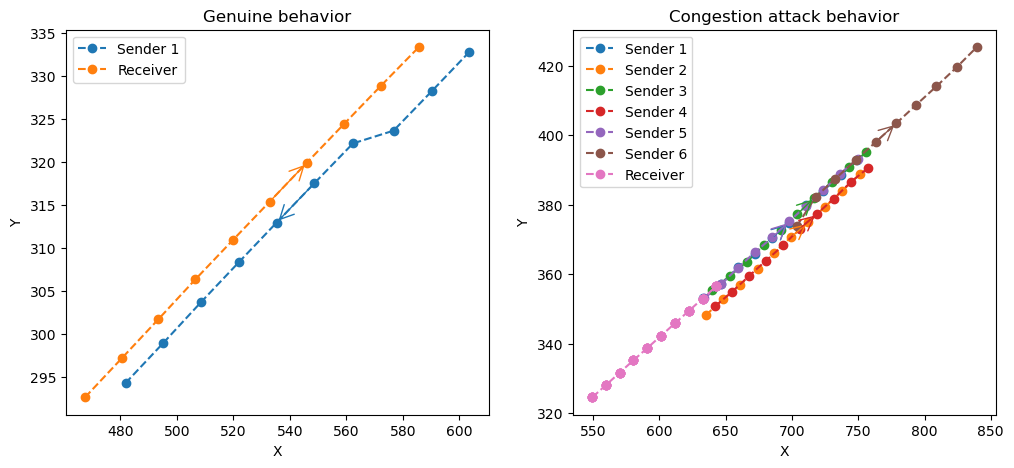

In [13]:
# df[df.attack_type == 0].groupby(['bsm_rcv_time_10s', 'sender', 'sender_pseudo', 'receiver']).snd_pos_x.size().sort_values(ascending=False)
# df[df.attack_type == 16].groupby(['bsm_rcv_time_10s', 'sender', 'sender_pseudo', 'receiver']).snd_pos_x.size().sort_values(ascending=False)

df['bsm_rcv_time_10s'] = df.bsm_rcv_time // 10

def draw(ax, sender, receiver, bsm_rcv_time_10s, title):
    def add_arrow(line, position=None, direction='right', size=25, color=None):
        """
        add an arrow to a line.

        line:       Line2D object
        position:   x-position of the arrow. If None, mean of xdata is taken
        direction:  'left' or 'right'
        size:       size of the arrow in fontsize points
        color:      if None, line color is taken.
        """
        if color is None:
            color = line.get_color()

        xdata = line.get_xdata()
        ydata = line.get_ydata()

        if position is None:
            position = xdata.mean()
        # find closest index
        start_ind = np.argmin(np.absolute(xdata - position))
        if direction == 'right':
            end_ind = start_ind + 1
        else:
            end_ind = start_ind - 1
        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="->", color=color),
            size=size
        )

    x = df[(df.sender == sender)
           & (df.receiver == receiver)
           & (df.bsm_rcv_time_10s == bsm_rcv_time_10s)]
    
    
    for i, sender_pseudo in enumerate(x.sender_pseudo.unique()):
        x_pseudo = x[x.sender_pseudo == sender_pseudo]
        line1 = ax.plot(x_pseudo.snd_pos_x, x_pseudo.snd_pos_y, linestyle='--', marker='o', label=f'Sender {i + 1}')[0]
        add_arrow(line1)

    line2 = ax.plot(x.rcv_pos_x, x.rcv_pos_y, linestyle='--', marker='o', label='Receiver')[0]
    add_arrow(line2)
    
    ax.legend()

    ax.set_title(title)
    ax.set_xlabel('X') # position x
    ax.set_ylabel('Y') # position y

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

draw(axes[0], sender=7449, receiver=7707, bsm_rcv_time_10s=5566, title='Genuine behavior')
draw(axes[1], sender=2973, receiver=2985, bsm_rcv_time_10s=5199, title='Congestion attack behavior')

fig.show()

## Dynamic graphs

A dynamic graph is one in which connections change over time. There are two main ways to represent dynamic graphs:

* Discrete dynamic graph: these are sequences of "snapshots" of static graphs.

* Continuous dynamic graph: more general representation, and are represented as lists of events with timestamps, which may include the addition or removal of edges, nodes or transformations of edge features.

The model chosen to be worked on is the Temporal Graph Network (TGN), presented in [1]. This model uses a continuous dynamic graph as input, therefore, it is necessary to transform the VeReMi data to apply the model.

### Data processing

The data is already in the form of event lists, so few changes are needed.

In this work, a case is tested where upon receiving the message, the user does not have the global ID of the sending vehicle, only a pseudonym used for occasional transmissions. This makes the work more complex to identify attackers, as each vehicle simulated by the attacker will be interpreted as a separate vehicle.

In [15]:
feats = ['snd_pos_x', 'snd_pos_y', 'snd_spd_x', 'snd_spd_y',
         'snd_acl_x', 'snd_acl_y', 'snd_hed_x', 'snd_hed_y',
         'rcv_pos_x', 'rcv_pos_y', 'rcv_spd_x', 'rcv_spd_y',
         'rcv_acl_x', 'rcv_acl_y', 'rcv_hed_x', 'rcv_hed_y']

# Order by received time
df.sort_values('bsm_rcv_time', inplace=True)

# Using pseudonym as a sender
df['sender_id'] = df.apply(lambda row: f"{row['sender']}_{row['sender_pseudo']}", axis=1)

# reset sender id
df['sender_id'], _ = pd.factorize(df['sender_id'])

# Reset receiver id
df['receiver_id'], _ = pd.factorize(df['receiver'])

# time as an integer
df['bsm_rcv_time'] = ((df.bsm_rcv_time - df.bsm_rcv_time.min()) * 1e3).astype(int)

def group_feats(x):
    return x[feats].tolist()

# Dataset structure [2]
data = pd.concat([
    pd.DataFrame({
        'sender': df.sender_id,
        'receiver': df.receiver_id,
        'timestamp': df.bsm_rcv_time,
        'y': (df.attack_type > 0).astype(int),
    }),
    df[feats],
], axis=1)

data.to_csv('data/VeReMi/congestion/raw/congestion.csv', index=False)

data

,sender,receiver,timestamp,y,snd_pos_x,snd_pos_y,snd_spd_x,snd_spd_y,snd_acl_x,snd_acl_y,snd_hed_x,snd_hed_y,rcv_pos_x,rcv_pos_y,rcv_spd_x,rcv_spd_y,rcv_acl_x,rcv_acl_y,rcv_hed_x,rcv_hed_y
message_id,,,,,,,,,,,,,,,,,,,,
8488.0,0,0,0,0,1317.556519,1013.471680,-0.905959,-1.427456,-0.919148,-1.448250,-0.540489,-0.841351,1370.894531,1273.314575,0.751064,-1.693233,0.821147,-1.851266,0.395492,-0.918469
8543.0,1,1,23,1,1370.894531,1273.314575,0.751064,-1.693233,0.821147,-1.851266,0.395492,-0.918469,1317.556519,1013.471680,-0.905959,-1.427456,-0.919148,-1.448250,-0.540489,-0.841351
8598.0,2,1,523,1,1323.744995,1023.234192,-0.901368,-1.481382,-0.919148,-1.448250,-0.544698,-0.838632,1316.286377,1011.183899,-1.902815,-2.998132,-1.038526,-1.636348,-0.544954,-0.838466
8652.0,0,0,1000,0,1316.286377,1011.183899,-1.902815,-2.998132,-1.038526,-1.636348,-0.544954,-0.838466,1372.008911,1270.613403,1.601821,-3.611291,1.022110,-2.304273,0.395492,-0.918469
8667.0,1,1,1023,1,1372.008911,1270.613403,1.601821,-3.611291,1.022110,-2.304273,0.395492,-0.918469,1316.286377,1011.183899,-1.902815,-2.998132,-1.038526,-1.636348,-0.544954,-0.838466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30255274.0,3716,1684,7195371,1,143.223511,914.516357,0.000325,0.000306,0.000315,0.000315,0.043755,-0.999042,153.086700,906.337280,0.002838,-0.038102,-0.002987,0.040353,0.018681,-0.999825
30255340.0,3657,1659,7195375,0,359.104095,250.957169,-10.341017,-3.913756,0.034676,0.013238,-0.976025,-0.217660,260.708710,220.149994,-0.654565,-0.104543,4.447416,0.718211,-0.999760,-0.021888
30255340.0,3657,1685,7195375,0,359.104095,250.957169,-10.341017,-3.913756,0.034676,0.013238,-0.976025,-0.217660,248.206650,197.392517,-2.261526,15.618645,0.075500,-0.520631,-0.119704,0.992810


The graph has 1501368 interactions, between 3726 senders and 1688 recipients. In this problem, the graph is treated as a bipartite graph, since the senders cannot be re-identified.

To consume the data, an `InMemoryDataset` present in the torch_geometric library is used, and this dataset contains `TemporalData`, which is the representation used for continuous dynamic graphs in this library.

Here, I reduced the number of features after some tests, leaving only the position and speed features of both the sender and the receiver.

This class was adapted from [2].

In [16]:
import os.path as osp
from typing import Callable, Optional
import torch
from torch_geometric.data import InMemoryDataset, TemporalData

class VeReMiDataset(InMemoryDataset):
    names = ['congestion']
    def __init__(
        self,
        root: str,
        name: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
    ):
        self.name = name.lower()
        assert self.name in self.names

        super().__init__(root, transform, pre_transform)
        self.load(self.processed_paths[0], data_cls=TemporalData)

    @property
    def raw_dir(self) -> str:
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self) -> str:
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self) -> str:
        return f'{self.name}.csv'

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def process(self):
        import pandas as pd
        df = pd.read_csv(self.raw_paths[0], skiprows=1, header=None)

        # sender
        src = torch.from_numpy(df.iloc[:, 0].values).to(torch.long)
        
        # receiver
        dst = torch.from_numpy(df.iloc[:, 1].values).to(torch.long)
        
        dst += int(src.max()) + 1
        
        # timestamp
        t = torch.from_numpy(df.iloc[:, 2].values).to(torch.long)
        
        # label, if it's an attack interaction or not
        y = torch.from_numpy(df.iloc[:, 3].values).to(torch.float)

        # message
        msg_src = torch.from_numpy(df.iloc[:, 4:8].values).to(torch.float)
        msg_dst = torch.from_numpy(df.iloc[:, 12:16].values).to(torch.float)
        msg = torch.cat([msg_src, msg_dst], axis=1)

        data = TemporalData(src=src, dst=dst, t=t, msg=msg, y=y)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        self.save([data], self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.name.capitalize()}()'

In [17]:
from torch_geometric.transforms import NormalizeFeatures

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = osp.join('data', 'VeReMi')

dataset = VeReMiDataset(path, name='congestion')
data = dataset[0]

data = data.to(device)

normalizer = NormalizeFeatures()
data = normalizer(data)

data

TemporalData(src=[1501368], dst=[1501368], t=[1501368], msg=[1501368, 8], y=[1501368])

In [18]:
print(f'Links/interactions: {data.num_edges}, Nodes: {data.num_nodes}')

Links/interactions: 1501368, Nodes: 5414


## Model

The model implementation was adapted from the example provided by the Torch Geometric library in [3].

A binary link classification model is used, and training is done in a supervised manner, using the attack labels provided in the dataset.

In [23]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

#### Module 1 - Load neighbors

The first step of the model is neighbor loading. For this, the `LastNeighborLoader` class present in the library is used. This class returns the last neighbors of the sample node found, which are stored in a graph that keeps growing during training and testing [4]. It will also return a subgraph containing the interactions between the searched node and its neighbors. It is used to sample the proximity of the region to the analyzed node.

#### Module 2 - Memory

The second part of the model is memory, which aims to represent the history of a node in a compressed format. When a node is found, its memory is initialized to zero and for each event involving that node, it is updated, building a structure that allows the memorization of long-term dependencies [1]. It uses a recurrent neural network of the Gated Recurrent Unit (GRU) type to update the memory. It is also already implemented in the library and is provided by the `TGNMemory` class.

#### Module 3 - Embedding with attention

This module is responsible for generating embeddings for the sample nodes in time t. It uses a temporal encoder provided in the `TGNMemory` module, which is a linear layer with a trigometric function at the end. It also uses a `TransformerConv` layer, which performs "message-passing" in the graph also using the attention mechanism of the Transformers models.

In [24]:
class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc, n_heads=2):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // n_heads, heads=n_heads,
                                    dropout=0, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr).relu()

#### Module 4 - Link Classifier

This module performs the edge classification based on the embedding generated in the previous module. It uses a simple dense neural network to perform this classification.

In [25]:
class LinkClassifier(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin = torch.nn.Sequential(
            torch.nn.Linear(in_channels * 2, in_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(in_channels, 1),
        )

    def forward(self, z_src, z_dst):
        h = torch.cat([z_src, z_dst], axis=1)
        return self.lin(h)

#### Final model

In [26]:
class TGN(torch.nn.Module):
    def __init__(self, memory_dim,
                       time_dim,
                       embedding_dim,
                       num_nodes,
                       msg_size,
                       n_heads,
                       neighbor_size):
        super().__init__()
        self.neighbor_loader = LastNeighborLoader(num_nodes, size=neighbor_size)

        self.memory = TGNMemory(
            num_nodes,
            msg_size,
            memory_dim,
            time_dim,
            message_module=IdentityMessage(msg_size, memory_dim, time_dim),
            aggregator_module=LastAggregator(),
        )
        
        self.gnn = GraphAttentionEmbedding(
            in_channels=memory_dim,
            out_channels=embedding_dim,
            msg_dim=msg_size,
            time_enc=self.memory.time_enc,
            n_heads=n_heads,
        )

        self.link_class = LinkClassifier(in_channels=embedding_dim)
        
        # Vetor auxiliar para mapear os nós globais para locais.
        assoc = torch.empty(num_nodes, dtype=torch.long, device=device)
        self.register_buffer('assoc', assoc)

    def reset(self):
        self.memory.reset_state() # Reseta a memória
        self.neighbor_loader.reset_state() # Reseta o grafo
    
    def update_memory(self, x):
        # Atualiza a memoria e a vizinhança
        self.memory.update_state(x.src, x.dst, x.t, x.msg)
        self.neighbor_loader.insert(x.src, x.dst)

    def forward(self, x, data):
        n_id, edge_index, e_id = self.neighbor_loader(x.n_id)
        self.assoc[n_id] = torch.arange(n_id.size(0))

        # Consulta a memória
        z, last_update = self.memory(n_id)
        
        z = self.gnn(z, last_update, edge_index, data.t[e_id], data.msg[e_id])

        out = self.link_class(z[self.assoc[x.src]], z[self.assoc[x.dst]])
        
        self.update_memory(x)

        return out

### Training

Training is conducted for 50 epochs, using a batch_size of 200, with a split of 80% for training and 20% for testing.

In [27]:
# hyperparameters
memory_dim = 256
time_dim = 256
embedding_dim = 256
neighbor_size = 20
n_heads = 4

model = TGN(memory_dim=memory_dim,
            time_dim=time_dim,
            embedding_dim=embedding_dim,
            num_nodes=data.num_nodes,
            msg_size=data.msg.size(-1),
            n_heads=n_heads,
            neighbor_size=neighbor_size).to(device)

In [28]:
train_data, _, test_data = data.train_val_test_split(
    val_ratio=0, test_ratio=0.2)

batch_size = 512

train_loader = TemporalDataLoader(
    train_data,
    batch_size=batch_size,
    neg_sampling_ratio=0,
)

test_loader = TemporalDataLoader(
    test_data,
    batch_size=batch_size,
    neg_sampling_ratio=0,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    model.reset()

    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)

        out = model(batch, data)
        loss = criterion(out, batch.y.unsqueeze(-1))

        loss.backward()
        optimizer.step()
        model.memory.detach()
        total_loss += float(loss) * batch.num_events

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader):
    model.eval()

    torch.manual_seed(12345)

    aps, aucs, ps, rs, f1s = [], [], [], [], []
    for batch in tqdm(loader):
        batch = batch.to(device)
        
        out = model(batch, data)

        y_pred = out.sigmoid().cpu()
        y_true = batch.y.unsqueeze(-1).cpu()

        aps.append(average_precision_score(y_true, y_pred))
        aucs.append(roc_auc_score(y_true, y_pred))
        ps.append(precision_score(y_true, y_pred > 0.5))
        rs.append(recall_score(y_true, y_pred > 0.5))
        f1s.append(f1_score(y_true, y_pred > 0.5))

    return (float(torch.tensor(aps).mean()),
            float(torch.tensor(aucs).mean()),
            float(torch.tensor(ps).mean()),
            float(torch.tensor(rs).mean()),
            float(torch.tensor(f1s).mean()))

In [11]:
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

    test_ap, test_auc, test_p, test_r, test_f1 = test(test_loader)
    print(f'''
Test AP: {test_ap:.4f}
Test AUC: {test_auc:.4f}
Test Precision {test_p:.4f}
Test Recall {test_r:.4f}
Test F1 {test_f1:.4f}
    ''')
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'auc': test_auc,
        'ap': test_ap,
    }
    torch.save(checkpoint, f'checks/{epoch}.pt')

  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 001, Loss: 0.6431


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.7636
Test AUC: 0.6168
Test Precision 0.6813
Test Recall 0.8853
Test F1 0.7634
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 002, Loss: 0.5765


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.8358
Test AUC: 0.7077
Test Precision 0.7028
Test Recall 0.8807
Test F1 0.7759
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 003, Loss: 0.5312


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.8031
Test AUC: 0.6698
Test Precision 0.7120
Test Recall 0.8230
Test F1 0.7576
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 004, Loss: 0.5213


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.8219
Test AUC: 0.7020
Test Precision 0.6991
Test Recall 0.9198
Test F1 0.7893
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 005, Loss: 0.4879


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.8344
Test AUC: 0.7297
Test Precision 0.7011
Test Recall 0.9546
Test F1 0.8049
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 006, Loss: 0.4687


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.8941
Test AUC: 0.8160
Test Precision 0.7486
Test Recall 0.9386
Test F1 0.8296
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 007, Loss: 0.4349


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.8920
Test AUC: 0.8137
Test Precision 0.7219
Test Recall 0.9543
Test F1 0.8182
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 008, Loss: 0.4281


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9101
Test AUC: 0.8393
Test Precision 0.7587
Test Recall 0.9411
Test F1 0.8363
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 009, Loss: 0.4106


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9189
Test AUC: 0.8504
Test Precision 0.7776
Test Recall 0.9255
Test F1 0.8408
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 010, Loss: 0.4190


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9158
Test AUC: 0.8475
Test Precision 0.8040
Test Recall 0.8997
Test F1 0.8437
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 011, Loss: 0.4198


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9281
Test AUC: 0.8658
Test Precision 0.8206
Test Recall 0.8983
Test F1 0.8524
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 012, Loss: 0.4105


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9203
Test AUC: 0.8533
Test Precision 0.8432
Test Recall 0.8728
Test F1 0.8525
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 013, Loss: 0.4098


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9209
Test AUC: 0.8540
Test Precision 0.8565
Test Recall 0.8652
Test F1 0.8555
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 014, Loss: 0.4123


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9219
Test AUC: 0.8569
Test Precision 0.8606
Test Recall 0.8631
Test F1 0.8565
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 015, Loss: 0.4090


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9298
Test AUC: 0.8691
Test Precision 0.8604
Test Recall 0.8727
Test F1 0.8614
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 016, Loss: 0.3941


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9297
Test AUC: 0.8690
Test Precision 0.8634
Test Recall 0.8658
Test F1 0.8595
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 017, Loss: 0.3985


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9304
Test AUC: 0.8663
Test Precision 0.8639
Test Recall 0.8672
Test F1 0.8607
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 018, Loss: 0.3941


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9296
Test AUC: 0.8679
Test Precision 0.8615
Test Recall 0.8725
Test F1 0.8619
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 019, Loss: 0.3968


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9233
Test AUC: 0.8573
Test Precision 0.8349
Test Recall 0.8824
Test F1 0.8526
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 020, Loss: 0.3981


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9328
Test AUC: 0.8718
Test Precision 0.8548
Test Recall 0.8809
Test F1 0.8628
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 021, Loss: 0.3838


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9326
Test AUC: 0.8714
Test Precision 0.8666
Test Recall 0.8717
Test F1 0.8647
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 022, Loss: 0.3770


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9362
Test AUC: 0.8766
Test Precision 0.8384
Test Recall 0.8919
Test F1 0.8600
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 023, Loss: 0.3809


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9375
Test AUC: 0.8799
Test Precision 0.8711
Test Recall 0.8697
Test F1 0.8664
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 024, Loss: 0.3761


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9350
Test AUC: 0.8746
Test Precision 0.8637
Test Recall 0.8727
Test F1 0.8643
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 025, Loss: 0.3780


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9261
Test AUC: 0.8593
Test Precision 0.8376
Test Recall 0.8814
Test F1 0.8546
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 026, Loss: 0.3800


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9375
Test AUC: 0.8781
Test Precision 0.8599
Test Recall 0.8819
Test F1 0.8670
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 027, Loss: 0.3693


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9375
Test AUC: 0.8780
Test Precision 0.8540
Test Recall 0.8769
Test F1 0.8612
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 028, Loss: 0.3804


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9277
Test AUC: 0.8610
Test Precision 0.8590
Test Recall 0.8613
Test F1 0.8556
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 029, Loss: 0.3736


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9340
Test AUC: 0.8731
Test Precision 0.8719
Test Recall 0.8599
Test F1 0.8611
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 030, Loss: 0.3659


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9274
Test AUC: 0.8610
Test Precision 0.8766
Test Recall 0.8387
Test F1 0.8525
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 031, Loss: 0.3753


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9293
Test AUC: 0.8637
Test Precision 0.8655
Test Recall 0.8559
Test F1 0.8561
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 032, Loss: 0.3684


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9421
Test AUC: 0.8872
Test Precision 0.8602
Test Recall 0.8835
Test F1 0.8674
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 033, Loss: 0.3605


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9275
Test AUC: 0.8615
Test Precision 0.8804
Test Recall 0.8391
Test F1 0.8546
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 034, Loss: 0.3670


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9354
Test AUC: 0.8743
Test Precision 0.8640
Test Recall 0.8610
Test F1 0.8581
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 035, Loss: 0.3587


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9325
Test AUC: 0.8695
Test Precision 0.8798
Test Recall 0.8519
Test F1 0.8608
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 036, Loss: 0.3606


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9401
Test AUC: 0.8806
Test Precision 0.8491
Test Recall 0.8833
Test F1 0.8620
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 037, Loss: 0.3567


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9367
Test AUC: 0.8736
Test Precision 0.8820
Test Recall 0.8443
Test F1 0.8585
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 038, Loss: 0.3502


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9382
Test AUC: 0.8764
Test Precision 0.8834
Test Recall 0.8472
Test F1 0.8609
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 039, Loss: 0.3484


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9400
Test AUC: 0.8820
Test Precision 0.8763
Test Recall 0.8691
Test F1 0.8683
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 040, Loss: 0.3466


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9412
Test AUC: 0.8838
Test Precision 0.8754
Test Recall 0.8592
Test F1 0.8631
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 041, Loss: 0.3457


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9388
Test AUC: 0.8812
Test Precision 0.8799
Test Recall 0.8656
Test F1 0.8688
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 042, Loss: 0.3568


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9292
Test AUC: 0.8627
Test Precision 0.8811
Test Recall 0.8320
Test F1 0.8515
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 043, Loss: 0.3736


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9324
Test AUC: 0.8678
Test Precision 0.8839
Test Recall 0.8351
Test F1 0.8542
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 044, Loss: 0.3722


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9330
Test AUC: 0.8689
Test Precision 0.8879
Test Recall 0.8284
Test F1 0.8514
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 045, Loss: 0.3585


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9337
Test AUC: 0.8682
Test Precision 0.8982
Test Recall 0.8091
Test F1 0.8464
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 046, Loss: 0.3426


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9424
Test AUC: 0.8835
Test Precision 0.8698
Test Recall 0.8654
Test F1 0.8629
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 047, Loss: 0.3404


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9349
Test AUC: 0.8720
Test Precision 0.8873
Test Recall 0.8165
Test F1 0.8452
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 048, Loss: 0.3392


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9407
Test AUC: 0.8801
Test Precision 0.8921
Test Recall 0.8409
Test F1 0.8614
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 049, Loss: 0.3304


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9294
Test AUC: 0.8618
Test Precision 0.8824
Test Recall 0.8069
Test F1 0.8380
    


  0%|          | 0/2346 [00:00<?, ?it/s]

Epoch: 050, Loss: 0.3399


  0%|          | 0/587 [00:00<?, ?it/s]


Test AP: 0.9259
Test AUC: 0.8523
Test Precision 0.9019
Test Recall 0.7597
Test F1 0.8180
    


## Results

Training went well, but it quickly converged to an upper limit of approximately 0.93 AP and 0.86 AUC. Choosing a model that arrived at this plateau as early as possible, the model with the weights from epoch 15 will be analyzed.

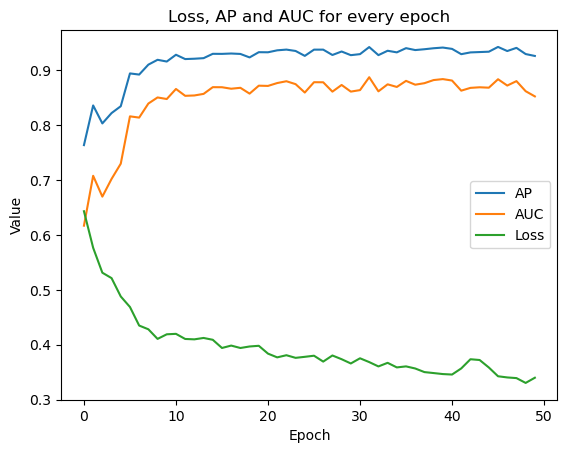

In [29]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    ap = checkpoint['ap']
    auc = checkpoint['auc']

    return model, optimizer, epoch, loss, ap, auc

aps = []
aucs = []
losses = []

for check in sorted(glob.glob('checks/*.pt'), key=lambda x: float(x[:-3].split('/')[1])):
    _, _, _, loss, ap, auc  = load_checkpoint(model, optimizer, check)
    aps.append(ap)
    aucs.append(auc)
    losses.append(loss)

plt.plot(aps, label='AP')
plt.plot(aucs, label='AUC')
plt.plot(losses, label='Loss')

plt.legend()

plt.xlabel('Epoch') # Epoch
plt.ylabel('Value') # Value

plt.title('Loss, AP and AUC for every epoch')

plt.show()

Using a threshold of 0.5 for the classier...

In [30]:
from sklearn.metrics import accuracy_score

model, _, _, loss, ap, auc  = load_checkpoint(model, optimizer, 'checks/15.pt')

ps = []
rs = []
f1s = []
accs = []


with torch.no_grad():
    model.eval()
    torch.manual_seed(12345)
    
    # Restarting and reloading the memory state
    model.reset()
    for batch in tqdm(train_loader):
        model.update_memory(batch)

    for batch in tqdm(test_loader):
        batch = batch.to(device)

        out = model(batch, data)

        y_pred = out.sigmoid().cpu()
        y_true = batch.y.unsqueeze(-1).cpu()

        ps.append(precision_score(y_true, y_pred > 0.5))
        rs.append(recall_score(y_true, y_pred > 0.5))
        f1s.append(f1_score(y_true, y_pred > 0.5))
        accs.append(accuracy_score(y_true, y_pred > 0.5))
    
    # Metrics
    acc = float(torch.tensor(accs).mean())
    r = float(torch.tensor(rs).mean())
    p = float(torch.tensor(ps).mean())
    f1 = float(torch.tensor(f1s).mean())

pd.DataFrame([{
    'Accuracy': acc,
    'Precision': p,
    'Recall': r,
    'F1': f1,
}])

  0%|          | 0/2346 [00:00<?, ?it/s]

  0%|          | 0/587 [00:00<?, ?it/s]

,Accuracy,Precision,Recall,F1
0,0.816981,0.862779,0.871389,0.862079


In [31]:
print(f'''
Amount of attacks in the full dataset: {float(data.y.sum() / data.y.shape[0])},
Amount of attacks in the test dataset: {float(test_loader.data.y.sum() / test_loader.data.y.shape[0])},
''')


Amount of attacks in the full dataset: 0.6486304402351379,
Amount of attacks in the test dataset: 0.662860095500946,



It was possible to achieve 81% accuracy in the task, with a precision of 86% and a recall of 87%, resulting in an F1 measure of 86%. This result, together with the fact that the dataset contains 64% of interactions as attacks, shows that the results were positive and that the model demonstrates acceptable performance for the task.

## Conclusion

In the tests carried out, the TGN Model managed to achieve a promising result, even with the limitations of the sender.

A limitation of this work is the lack of comparisons with other methods to validate the quality of the results obtained with this model. Also, no optimizations were made to the hyperparameters in order to maximize performance.

Finally, it is concluded that the TGN technique is very interesting and can be applied in the context of identifying attacks in VANETs.

## References 

[1] Rossi, E., Chamberlain, B., Frasca, F., Eynard, D., Monti, F., & Bronstein, M. (2020). Temporal Graph Networks for Deep Learning on Dynamic Graphs. Available at: https://arxiv.org/abs/2006.10637

[2] Torch Geometric Team. JODIE Dataset Loader. Available at: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/jodie.html#JODIEDatase

[3] Torch Geometric Team. Temporal Graph Network (TGN) example. Available at: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/tgn.py

[4] Torch Geometric Team. Question about LastNeighborLoader. GitHub Issues. Available at: https://github.com/pyg-team/pytorch_geometric/discussions/2153

[5] J. Kamel and M. Wolf and R. W. van Der Heijden and A. Kaiser and P. Urien and F. Kargl. VeReMi Extension: A Dataset for Comparable Evaluation of Misbehavior Detection in VANETs. Available at: https://github.com/josephkamel/VeReMi-Dataset.